# Convert new .model and .json files to huggingface tokenizer

In [1]:
import json
from transformers import AutoTokenizer
from train_tokenizer import read_training_info
from efficient_tokenization import tokenize_simple


/nfshomes/astein0/.pyenv/versions/3.10.4/envs/eff-tok/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

def convert_tokenizer_to_huggingface(new_tokenizer_info_path: str, original_tokenizer: str):
    # must get original tokenizer from huggingface
    tokenizer = AutoTokenizer.from_pretrained(original_tokenizer)
    # load new_tokenizer_info_path
    new_tokenizer_info = read_training_info(new_tokenizer_info_path)
    # get merges and new_tokens
    merges = new_tokenizer_info["merges"]
    new_tokens = new_tokenizer_info["new_tokens"]
    # add new tokens to tokenizer
    tokenizer.add_tokens(new_tokens)
    return tokenizer

info_path = "/cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start/new_mergeable_ranks_128266.json"
original_tokenizer = "meta-llama/Llama-3.2-1B"

# tok = convert_tokenizer_to_huggingface(info_path, original_tokenizer)

In [ ]:
def convert_tokenizer_to_huggingface_correct(new_tokenizer_info_path: str, original_tokenizer: str):
    # must get original tokenizer from huggingface
    tokenizer = AutoTokenizer.from_pretrained(original_tokenizer)
    tokenizer_json = json.loads(tokenizer._tokenizer.to_str())
    
    # old_vocab = tokenizer_json["model"]["vocab"]
    # starting_index = len(tokenizer.get_vocab())
    old_merges = tokenizer_json["model"]["merges"]

    # Extract vocab (token: index)
    old_vocab = tokenizer.get_vocab()
    
    # load new_tokenizer_info_path
    new_tokenizer_info = read_training_info(new_tokenizer_info_path)
    # get merges and new_tokens
    new_merges = new_tokenizer_info["merges"]
    new_tokens = new_tokenizer_info["new_tokens"]

    # Update vocab (append at the next available ID)
    new_vocab = {**old_vocab}  # Copy the old vocab
    starting_index = max(old_vocab.values()) + 1

    for i, token in enumerate(new_tokens):
        new_vocab[token] = starting_index + i

    new_vocab_sorted = dict(sorted(new_vocab.items(), key=lambda item: item[1]))
    # new_vocab_sorted = new_vocab

    joined_merges = [x for x in old_merges]
    joined_merges.extend(new_merges)

    added_tokens = tokenizer.get_added_vocab()
    add_tok_ids = [tok_id for tok, tok_id in added_tokens.items()]

    new_vocab_sorted_no_added = {tok: tok_id for  tok, tok_id in new_vocab_sorted.items() if tok_id not in add_tok_ids}

    new_tokenizer_info = {**tokenizer_json}
    new_tokenizer_info["model"]["vocab"] = new_vocab_sorted_no_added
    new_tokenizer_info["model"]["merges"] = joined_merges

    # add new tokens to tokenizer
    return new_tokenizer_info

info_path = "/cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start/new_mergeable_ranks_128266.json"
original_tokenizer_str = "meta-llama/Llama-3.2-1B"

new_tokenizer_json = convert_tokenizer_to_huggingface_correct(info_path, original_tokenizer_str)



In [ ]:
# 5️⃣ Reload tokenizer to verify it works
new_tokenizer = AutoTokenizer.from_pretrained(new_tokenizer_path)

# 6️⃣ Check vocab size to confirm new tokens were added
print(f"✅ New tokenizer loaded! Vocab size: {len(new_tokenizer.get_vocab())}")


In [3]:
original_tokenizer = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(original_tokenizer)
tokenizer_json = json.loads(tokenizer._tokenizer.to_str())
    
old_vocab = tokenizer_json["model"]["vocab"]
starting_index = len(tokenizer)


 # DUPLICATING the dataset

In [7]:
from transformers import AutoTokenizer
import psutil
import datasets

batch_size = 500

try:
    threads = min(psutil.cpu_count(logical=False), len(psutil.Process().cpu_affinity()))
except:
    threads = os.cpu_count()

import logging
log = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,  # Set the minimum log level
    format="%(asctime)s - %(levelname)s - %(message)s",  # Include time, level, and message
    datefmt="%Y-%m-%d %H:%M:%S"  # Specify the date and time format
)

# Load the model and tokenizer
log.info("Loading model and tokenizer...")
model_name = "meta-llama/Llama-3.2-1B"
# new_tokenizer_path = "/cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start-1000"
new_tokenizer_path ="/cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start-10"

log.info("Loading base tokenizer...")
base_tokenizer = AutoTokenizer.from_pretrained(model_name)
log.info("Loading extended tokenizer...")
extended_tokenizer = AutoTokenizer.from_pretrained(new_tokenizer_path)

log.info("Loading dataset...")
ds_path = "/fs/cml-projects/llm-pretraining/datasets/raw/genqa/math"
ds = datasets.load_from_disk(ds_path)

log.info("Getting genqa data...")
ds = tokenize_simple.get_genqa_data(ds, track_role=True, batch_size=batch_size, threads=threads)
# log.info("Creating translation dataset...")
# ds = create_translation_dataset(ds, base_tokenizer, extended_tokenizer, batch_size, threads)

2025-03-20 01:57:58 - INFO - Loading model and tokenizer...
2025-03-20 01:57:58 - INFO - Loading base tokenizer...
2025-03-20 01:57:59 - INFO - Loading extended tokenizer...
2025-03-20 01:58:00 - INFO - Loading dataset...
2025-03-20 01:58:00 - INFO - Getting genqa data...


In [4]:
import importlib
importlib.reload(tokenize_simple)
print(ds)

log.info("Creating translation dataset...")
# ds = tokenize_simple.create_translation_dataset(ds, base_tokenizer, extended_tokenizer, 2, threads)
ds = tokenize_simple.create_translation_dataset_with_template(ds, base_tokenizer, new_tokenizer_path, 2, threads)

2025-03-05 21:39:51 - INFO - Creating translation dataset...


Dataset({
    features: ['text'],
    num_rows: 515509
})
The OrderedVocab you are attempting to save contains holes for indices [128000, 128001, 128002, 128003, 128004, 128005, 128006, 128007, 128008, 128009, 128010, 128011, 128012, 128013, 128014, 128015, 128016, 128017, 128018, 128019, 128020, 128021, 128022, 128023, 128024, 128025, 128026, 128027, 128028, 128029, 128030, 128031, 128032, 128033, 128034, 128035, 128036, 128037, 128038, 128039, 128040, 128041, 128042, 128043, 128044, 128045, 128046, 128047, 128048, 128049, 128050, 128051, 128052, 128053, 128054, 128055, 128056, 128057, 128058, 128059, 128060, 128061, 128062, 128063, 128064, 128065, 128066, 128067, 128068, 128069, 128070, 128071, 128072, 128073, 128074, 128075, 128076, 128077, 128078, 128079, 128080, 128081, 128082, 128083, 128084, 128085, 128086, 128087, 128088, 128089, 128090, 128091, 128092, 128093, 128094, 128095, 128096, 128097, 128098, 128099, 128100, 128101, 128102, 128103, 128104, 128105, 128106, 128107, 128108

Traceback (most recent call last):
  File "/nfshomes/astein0/.pyenv/versions/3.10.4/envs/eff-tok/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/nfshomes/astein0/.pyenv/versions/3.10.4/envs/eff-tok/lib/python3.10/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/nfshomes/astein0/.pyenv/versions/3.10.4/envs/eff-tok/lib/python3.10/site-packages/multiprocess/managers.py", line 599, in _run_server
    server.serve_forever()
  File "/nfshomes/astein0/.pyenv/versions/3.10.4/envs/eff-tok/lib/python3.10/site-packages/multiprocess/managers.py", line 184, in serve_forever
    sys.exit(0)
SystemExit: 0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/nfshomes/astein0/.pyenv/versions/3.10.4/envs/eff-tok/lib/python3.10/site-packages/multiprocess/util.py", line 300, in _run_finalizers
    finalizer()
  File "/nfshomes/as

In [ ]:
import datasets
ds_path = "/cmlscratch/astein0/efficient_tokenization_for_inference/datasets/translation_tokenized"
ds = datasets.load_from_disk(ds_path)

# converting tokenizer to fewer tokens added

In [2]:
from transformers import AutoTokenizer

tokenizer_path = "/cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start-1000"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
print(f"Loaded HF tokenizer from vocab file: {tokenizer_path}")
print(len(tokenizer.get_vocab()))

Loaded HF tokenizer from vocab file: /cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start-1000
129256


In [5]:
import os
import json
import efficient_tokenization.tokenization_utils

import importlib
importlib.reload(efficient_tokenization.tokenization_utils)

with open(os.path.join(tokenizer_path, "training_info.json"), "r") as f:
    tokenizer_json = json.load(f)

print(tokenizer_json.keys())
print(len(tokenizer_json["merges"]))
print(len(tokenizer_json["sizes"]))
print(len(tokenizer_json["new_tokens"]))
print(tokenizer_json["static_info"])
print(tokenizer_json["state"])


NameError: name 'tokenizer_path' is not defined

In [4]:
import importlib
importlib.reload(efficient_tokenization.tokenization_utils)
new_save_path = "/cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/testing"
sm = efficient_tokenization.tokenization_utils.SaveModule.from_path(old_path=tokenizer_path, new_path=new_save_path)

NameError: name 'efficient_tokenization' is not defined

In [9]:
merges = tokenizer_json["merges"]
sizes = tokenizer_json["sizes"]
# additional_info = tokenizer_json["additional_info"]
num_added_tokens = 100

sm.shrink_tokenizer(merges, sizes, num_added_tokens=num_added_tokens)

Saving tokenizer to /cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/testing


In [ ]:
import efficient_tokenization

tokenizer_path1 = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer_path2 = "meta-llama/Llama-3.2-3B-Instruct"
tok1 = AutoTokenizer.from_pretrained(tokenizer_path1)
tok2 = AutoTokenizer.from_pretrained(tokenizer_path2)

vocab1 = tok1.get_vocab()
vocab2 = tok2.get_vocab()

efficient_tokenization.tokenization_utils.compare_dicts(vocab1, vocab2)






True

# Now run the truncation for a bunch of sizes

In [ ]:
import importlib
importlib.reload(efficient_tokenization.tokenization_utils)
# sm = efficient_tokenization.tokenization_utils.SaveModule.from_path(old_path=tokenizer_path)
merges = tokenizer_json["merges"]
sizes = tokenizer_json["sizes"]
# additional_info = tokenizer_json["additional_info"]
num_new_tokens_list = [1, 5, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900]
for num_new_tokens in num_new_tokens_list:
    path = efficient_tokenization.tokenization_utils.get_new_path(num_new_tokens, tokenizer_path)
    sm.shrink_tokenizer(merges, sizes, num_new_tokens=num_new_tokens, new_path=path)



Setting save_loc to /cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start-1
Saving tokenizer to /cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start-1
Setting save_loc to /cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start-5
Saving tokenizer to /cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start-5
Setting save_loc to /cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start-20
Saving tokenizer to /cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start-20
Setting save_loc to /cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start-50
Saving tokenizer to /cmlscratch/astein0/efficient_tokenization_for

In [1]:
# Code to convert extended tokenizer to added tokens
from transformers import AutoTokenizer
import json
import os
from efficient_tokenization.tokenization_utils import SaveModule

base_tokenizer_path = "meta-llama/Llama-3.2-3B-Instruct"
original_tokenizer_path = "tokenizers/Llama-3.2-tokenizer-magpie_pro_300k_filtered-math-empty-start-1000"
print(f"Loading tokenizer from {original_tokenizer_path}")
tokenizer = AutoTokenizer.from_pretrained(original_tokenizer_path)

with open(os.path.join(original_tokenizer_path, "training_info.json"), "r") as f:
    tokenizer_json = json.load(f)

merges = tokenizer_json["merges"]
sizes = tokenizer_json["sizes"]

num_new_tokens = 1000
path = "tokenizers/Llama-3.2-tokenizer-magpie_pro_300k_filtered-math-empty-start-1000-modified"

sm = SaveModule.from_path(original_tokenizer_path)

sm.shrink_tokenizer(num_new_tokens, merges, sizes, new_path=path, added_tokens=True)



/nfshomes/astein0/.pyenv/versions/3.10.4/envs/eff-tok/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading tokenizer from tokenizers/Llama-3.2-tokenizer-magpie_pro_300k_filtered-math-empty-start-1000
{'pretokenizer_name': 'empty', 'cont_or_start': 'start', 'save_tokenized_data': True, 'old_tokenzer_info': None, 'base_tokenizer_path': 'meta-llama/Llama-3.2-1B-Instruct', 'save_path': 'tokenizers/Llama-3.2-tokenizer-magpie_pro_300k_filtered-math-empty-start-1000', 'original_dataset_size': 203249954, 'initial_vocab_size': 128256, 'created_from_path': 'tokenizers/Llama-3.2-tokenizer-magpie_pro_300k_filtered-math-empty-start-1000'}
Setting save_loc to tokenizers/Llama-3.2-tokenizer-magpie_pro_300k_filtered-math-empty-start-1000-modified
Saving tokenizer to tokenizers/Llama-3.2-tokenizer-magpie_pro_300k_filtered-math-empty-start-1000-modified


In [2]:
import json
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, decoders
from transformers import PreTrainedTokenizerFast

def load_tokenizer_json_correctly(tokenizer_json_path):
    with open(tokenizer_json_path, "r", encoding="utf-8") as f:
        tokenizer_data = json.load(f)

    # Step 1: Merge vocab + added_tokens manually
    base_vocab = tokenizer_data["model"]["vocab"]
    added_tokens = tokenizer_data.get("added_tokens", [])

    merged_vocab = {**base_vocab}
    for token in added_tokens:
        merged_vocab[token["content"]] = token["id"]

    # Step 2: Build BPE model from merged vocab
    merges = tokenizer_data["model"].get("merges", [])
    merges = [tuple(merge) for merge in merges]
    bpe_model = models.BPE(vocab=merged_vocab, merges=merges, dropout=None, unk_token=None)

    tokenizer = Tokenizer(bpe_model)

    # Step 3: Rebuild pre-tokenizer, decoder, etc (same as before)
    pretokenizer_info = tokenizer_data.get("pre_tokenizer", {})
    if pretokenizer_info.get("type") == "ByteLevel":
        tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(
            add_prefix_space=pretokenizer_info.get("add_prefix_space", False),
            trim_offsets=pretokenizer_info.get("trim_offsets", True),
            use_regex=pretokenizer_info.get("use_regex", True)
        )

    decoder_info = tokenizer_data.get("decoder", {})
    if decoder_info.get("type") == "ByteLevel":
        tokenizer.decoder = decoders.ByteLevel(
            add_prefix_space=decoder_info.get("add_prefix_space", True),
            trim_offsets=decoder_info.get("trim_offsets", True),
            use_regex=decoder_info.get("use_regex", True)
        )

    # Step 4: Wrap into PreTrainedTokenizerFast
    hf_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer)

    return hf_tokenizer

# Usage Example
tokenizer = load_tokenizer_json_correctly("/cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-magpie_pro_300k_filtered-math-empty-start-1000/tokenizer.json")

# 🔥 Test that your reserved_special_tokens are intact
print(f"tokenizer.convert_ids_to_tokens(128034) should be <|reserved_special_token_26|> : {tokenizer.convert_ids_to_tokens(128034)}")  # Should print <|reserved_special_token_26|>
print(f"tokenizer.convert_tokens_to_ids('<|reserved_special_token_26|>') should be 128034: {tokenizer.convert_tokens_to_ids('<|reserved_special_token_26|>')}")  # Should print 128034
print(f"tokenizer.convert_ids_to_tokens(129034) should be 'ĠrefersĠtoĠthe': {tokenizer.convert_ids_to_tokens(129034)}") # Should print "ĠrefersĠtoĠthe"
print(f"tokenizer.convert_tokens_to_ids('ĠrefersĠtoĠthe') should be 129034: {tokenizer.convert_tokens_to_ids('ĠrefersĠtoĠthe')}") # Should print 129034


/nfshomes/astein0/.pyenv/versions/3.10.4/envs/eff-tok/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tokenizer.convert_ids_to_tokens(128034) should be <|reserved_special_token_26|> : <|reserved_special_token_26|>
tokenizer.convert_tokens_to_ids('<|reserved_special_token_26|>') should be 128034: 128034
tokenizer.convert_ids_to_tokens(129034) should be 'ĠrefersĠtoĠthe': ĠrefersĠtoĠthe
tokenizer.convert_tokens_to_ids('ĠrefersĠtoĠthe') should be 129034: 129034


# Plotting compression curves

In [5]:
import json

path1 = "/cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-magpie_pro_300k_filtered-math-empty-start-1000/training_info.json"
path2 = "/cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/qwen_gsm8k-1000/training_info.json"
path3 = "/cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/phi_gsm8k_cot-1000/training_info.json"

data_dict = {
    "llama_3.2-3B": {
        "path": path1,
        "name": "Llama-3.2-3B"
    },
    "qwen_gsm8k": {
        "path": path2,
        "name": "Qwen-Gsm8k"
    },
    "phi_gsm8k_cot": {
        "path": path3,
        "name": "Phi-Gsm8k-COT"
    }
}

# all_data = []
for key, values in data_dict.items():
    with open(values["path"], "r") as f:
        data = json.load(f)
        # values["data"] = data
        # Extract compression rates
        original_dataset_size = data["static_info"]["original_dataset_size"]
        sizes = [original_dataset_size] + data["sizes"]
        compression_rates = [(original_dataset_size - x) / original_dataset_size for x in sizes]
        values["compression_rates"] = compression_rates




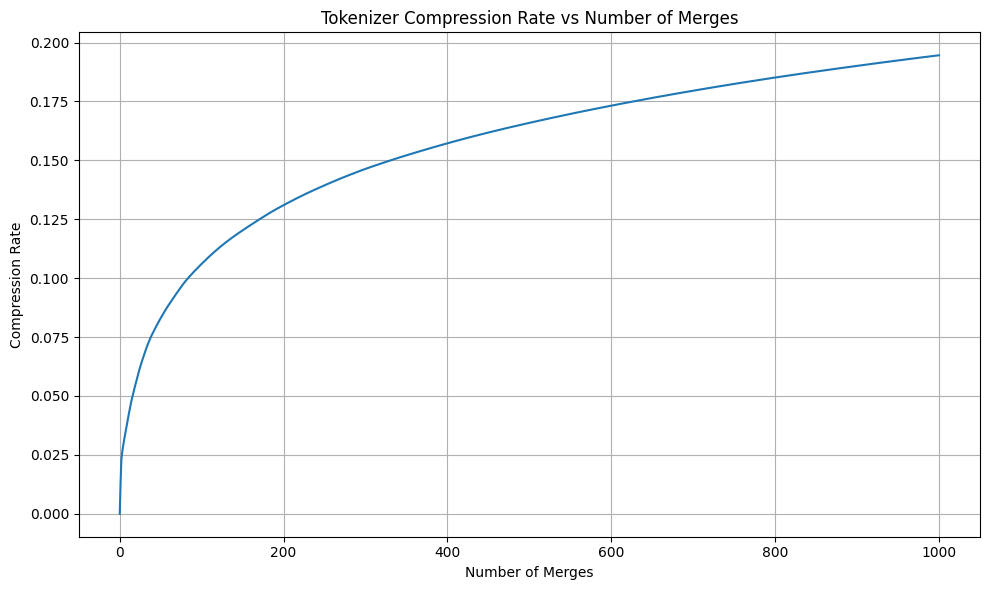

In [ ]:
import matplotlib

import matplotlib.pyplot as plt
import numpy as np


# Create x-axis (number of merges)
x = np.arange(len(compression_rates))

# Create the plot
plt.figure(figsize=(10, 6))
for key, values in data_dict.items():
    plt.plot(x, values["compression_rates"], label=values["name"]
             )
plt.xlabel('Added tokens')
plt.ylabel('Compression Rate')
# plt.title('Tokenizer Compression Rate vs Number of Merges')
plt.grid(True)

# Add a horizontal line at y=1.0 for reference
# plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()


